# History Matching for L96
Author : Redaoune Lguensat, Homer Durand

last modification : 28-07-21

### Loading libs

In [1]:
PATH = '/home/homer/anaconda3/envs/HM/bin/python'
Sys.setenv(RETICULATE_PYTHON = PATH)

current_dir <- getwd()
mogp_dir <- current_dir #mogp_emulator lib : https://github.com/alan-turing-institute/mogp-emulator
source("libs/utils.R")
source("libs/HistoryMatching.R")
source("libs/emulators.R")
setwd(paste0(current_dir, '/dev_ExeterUQ_MOGP/')) #devel version og ExeterUQ_MOGP : https://github.com/BayesExeter/ExeterUQ_MOGP/tree/devel

source("BuildEmulator/BuildEmulator_rf.R")
source("HistoryMatching/HistoryMatching_rf.R")
source("HistoryMatching/impLayoutplot.R")

setwd(current_dir)
source("morf.R")

r_packages <- c("future.apply", 'tgp', 'ANN2', 'MLmetrics', 'keras', 'quantregForest')
invisible(lapply(r_packages, library, character.only = TRUE))

l96pckg <- "L96_amip"  #for amip style experiment

python_pkg <- c(l96pckg, "numpy", "sklearn", "skopt.sampler", "skopt.space")
python_pkg_names <- c("L96_amip", "np", "sklearn", "sampler", "skSpace")
for(i in seq(length(python_pkg))){assign(python_pkg_names[i], import(python_pkg[i]))}

far library : Modelization for Functional AutoRegressive processes


version 0.6-4 (2014-12-07)


Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

Loading required package: future


Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall



Attaching package: ‘keras’


The following

In [2]:
np$random$seed(as.integer(42))

X_init = 10*np$ones(as.integer(36))
X_init[19]=1.0001 #ATtention X_init[19] !!!

l96_two = L96_amip$L96TwoLevel(save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

We first iterate 10 iterations in order to access to the steady state of the L96 model

In [3]:
l96_two$iterate(10)

In [4]:
X_init = l96_two$X

We can use *Newinit* to be sure to start from the attractor of the L96.

In [5]:
np$random$seed(as.integer(42))
n_iter <- 20
dt <- 0.001
l96_two = L96_amip$L96TwoLevel(save_dt=dt, X_init=X_init, integration_type='coupled') 

In [6]:
l96_two$iterate(n_iter)

We save the history of X in order to reinject it during the Y integration.

We save the metrics generate with the ground truth parameters (observations).

In [7]:
amip <- FALSE
system.time(observations <- l96_two$mean_stats(ax=as.integer(0), amip_metrics=amip))

   user  system elapsed 
  0.153   0.028   0.181 

We now have our ground truth metrics and history of X wo we can tune our model.

### Generation of metrics for the first wave

We first sample the parameters space (input space) using a space filling design (latin hypercube sampling with maximin criterion) and then will generate our metrics for each of those points of the parameter space.

In [9]:
n_samples <- 40

In [10]:
space <- skSpace$Space(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20))) 
lhs <- sampler$Lhs()  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave1 <- np$array(lhs$generate(space$dimensions, as.integer(n_samples), random_state=as.integer(42)))
#inputs_wave1 <- space$rvs(as.integer(n_samples)) # for random sampling

As a rule of thumb, we use 10 samples by paramaters. Here we have 3 parameters to tune (h, c, b), so we use 30 samples.

In [11]:
extract_metrics <- function(p, n_iter, dt, X_init, amip=FALSE) {
    l96_mip = L96_amip$L96TwoLevel(X_init=X_init, save_dt=dt, dt=dt, noYhist=FALSE, h=p[[1]], F=p[[2]], c=p[[3]], b=p[[4]])
    l96_mip$iterate(n_iter)
    return(l96_mip$mean_stats(ax=as.integer(0), amip_metrics=amip))
}

In [12]:
plan(multicore, workers=6)
metrics_wave1 = future_sapply(1:nrow(inputs_wave1), function(r) extract_metrics(inputs_wave1[r,], n_iter, 0.001, X_init, amip), future.seed=NULL) 
metrics_wave1 <- t(metrics_wave1)

### Create the data matrix

#### Scaling and Unscaling functions

In [13]:
amip <- FALSE
if(amip){
    idxs_metrics <- seq(65)

}else{
    idxs_metrics <- seq(180)
}

In [14]:
# Arrange inputs (parameters) 
inputs_wave1 <- data.frame(inputs_wave1)
my_bounds <- data.frame(list(c(-2, 2), c(-20,20), c(0, 20), c(-20, 20)))
inputs_wave1_scaled <- rangeScale(inputs_wave1, my_bounds, range = c(-1, 1))
names(inputs_wave1_scaled) <- c('h', 'F', 'c', 'b')

metrics_names <- c(paste0('X', seq(36)), paste0('Y_bar', seq(36)), paste0('X_sq', seq(36)), paste0('XY_bar', seq(36)), paste0('Y_bar_sq', seq(36)))
scaler <- sklearn$preprocessing$StandardScaler()
metrics_wave1_scaled <- scaler$fit_transform(data.frame(metrics_wave1)[, idxs_metrics])
names(metrics_wave1_scaled) <- metrics_names[idxs_metrics]

N = nrow(inputs_wave1) 
noise <- rnorm(N, 0.5, 0)
tData <- data.frame(cbind(inputs_wave1_scaled, noise, metrics_wave1_scaled))
names(tData)[names(tData) == "noise"] <- "Noise"
         

### Training emulator

In [15]:
cands <- names(tData)[1:4]
em_wave1 <- BuildNewEmulators(tData, HowManyEmulators = ncol(tData)-5, meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.663654083836332 using F"
[1] "Max reduction is 0.00375430474989713 using c"
[1] "Max reduction is 0.00149368595871291 using F"
[1] "Max reduction is 0.0523496348187884 using F"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ F + I(F^2) + I(F^3) + c + I(c * F), data = tData)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46517 -0.20848  0.01239  0.15780  0.65602 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.07435    0.06932  -1.073  0.29102    
F            2.35065    0.20212  11.630 2.13e-13 ***
I(F^2)       0.20054    0.15462   1.297  0.20335    
I(F^3)      -1.18365    0.30871  -3.834  0.00052 ***
c           -0.03318    0.08061  -0.412  0.68319    
I(c * F)    -0.17749    0.13597  -1.305  0.20054    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2915 on 34 degrees of freedom
Multiple R-squared:  0.9278,	Adjusted R-squared:  0.9172 
F-statisti

### Compute implausibility

We will compute implausibility as it is described in *Williamson & al. (2017)*.

$$
I_i(x_0) = \frac{|z_i - \mathbf{E}[f_i(x_0)]|}{|Var[z_i - \mathbf{E}[f_i(x_0)]]|} \\
I(x_0) = max_i(I_i(x_0))
$$

We consider that $Var[z_i - \mathbf{E}[f_i(x_0)]] = Var[e] +
Var[g] + Var[f(x_0)]$  like it is describe in *Williamson & al. (2017)*. 

With $Var[e]$ the observational
error variance, $Var[g]$ the model discrepancy variance
and $Var[f(x)]$ the variance of the emulator.

In [16]:
tDisc <- rep(0, ncol(metrics_wave1_scaled)) # model discrepancy variance Var[g] 
tObsErr <- rep(0, ncol(metrics_wave1_scaled)) # observational error variance Var[e]
tObs <-  scaler$transform(t(data.frame(observations[idxs_metrics])))# Observations

We generate a large sampling of the parameter space (that we have scaled) and will compute implausibility for each point of this parameters space.

In [18]:
sample_size <- 10000
nparam <- length(names(inputs_wave1))
space <- skSpace$Space(list(c(-1, 1), c(-1, 1), c(-1, 1), c(-1, 1))) ## we use a scaled space
Xp <- data.frame(np$array(space$rvs(as.integer(sample_size))))
names(Xp) <- names(inputs_wave1_scaled)
system.time(Timps <- ImplausibilityMORF(Emulator=em_wave1, NewData=Xp, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 19.982   6.980  10.846 

In [19]:
VarNames <- names(inputs_wave1_scaled)
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off
param.def = data.frame(h=c(1),F=c(10),c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

    h   F c   b
1 0.5 0.5 0 0.5


In [20]:
NROY1 <- which(rowSums(Timps <= cutoff) >= em_wave1$n_emulators -valmax)
scoreNROY1 <- length(NROY1)/dim(Xp)[1]
scoreNROY1

[1] 0.0773

### Layout of NROY space

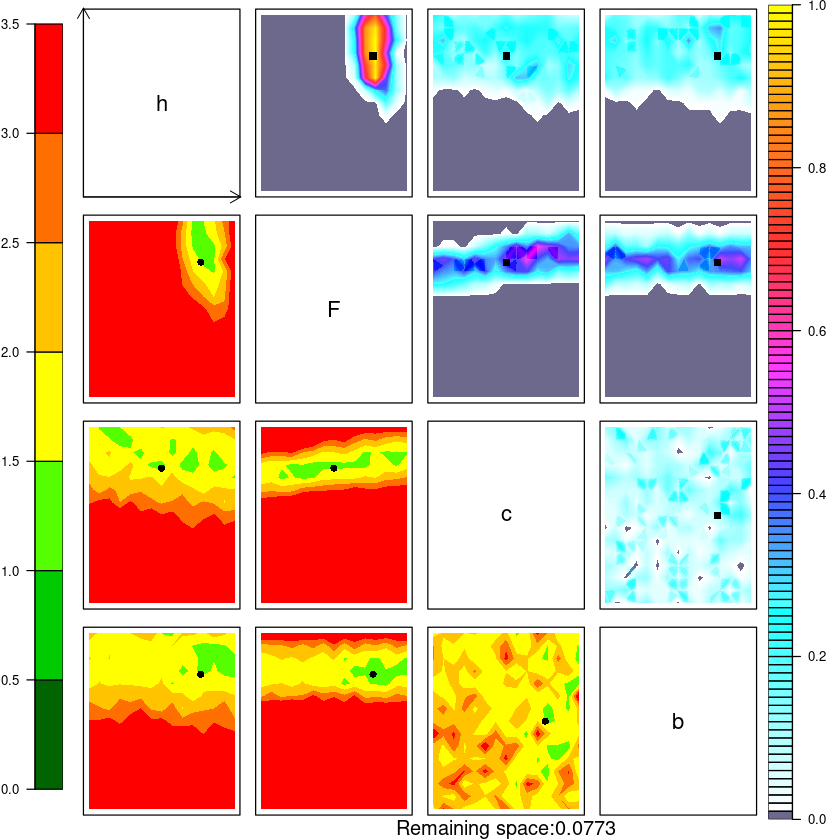

In [21]:
ImpData_wave1 = cbind(Xp, Timps)
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=em_wave1$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY1,sep=""), side=1)

## Second Wave

We will generate a large number of samples in the entire parameters space in order to obtain *n_samples* samples in the NROY space created with the emulator *em_wave1*.

In [22]:
n <- ceiling(n_samples*2/scoreNROY1)

In [23]:
space <- skSpace$Space(list(c(-1, 1), c(-1, 1), c(-1, 1), c(-1, 1))) ## we use a scaled space
lhs <- sampler$Lhs()  #(lhs_type='classic', criterion='maximin', iterations=1000)
inputs_wave2_scaled_temp <- data.frame(np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42))))
names(inputs_wave2_scaled_temp) <- names(inputs_wave1_scaled)

We find the points of NewData wich fall in the NROY space of each emulator in *emulators*.

In [24]:
emulators <- list(em_wave1)
NROY_temp_wave2 <- parameters_space(emulators, inputs_wave2_scaled_temp, tObs, tObsErr, tDisc, em_type='RF', n_samples=n_samples)

We now have our new inputs for wave 2.

We need to unscale those inputs for metrics simulations.

In [25]:
input_wave2_scaled <- inputs_wave2_scaled_temp[NROY_temp_wave2,]
input_wave2 <- rangeUnscale(input_wave2_scaled, my_bounds, range = c(-1, 1))

In [ ]:
metrics_wave2 = future_sapply(1:nrow(input_wave2), function(r) extract_metrics(input_wave2[r,], n_iter, 0.001, X_init, amip), future.seed=NULL) 
metrics_wave2 <- t(metrics_wave2)

### Create the data matrix

In [ ]:
input_wave2_scaled <- data.frame(input_wave2_scaled)
names(input_wave2_scaled) <- c('h', 'F', 'c', 'b')

metrics_wave2_scaled <- scaler$transform(data.frame(metrics_wave2)[, idxs_metrics])
names(metrics_wave2_scaled) <- metrics_names[idxs_metrics]

tData_wave2 <- data.frame(cbind(input_wave2_scaled, noise, metrics_wave2_scaled))
names(tData_wave2)[names(tData_wave2) == "noise"] <- "Noise"

### Training emulator

In [ ]:
em_wave2 <- BuildNewEmulators(tData_wave2, HowManyEmulators = ncol(tData_wave2)-5, meanFun = "fitted", additionalVariables = cands, lm.prefit=lm.prefit, ntree=50) # 

### Compute implausibility

In [ ]:
system.time(Timps_wave2 <- ImplausibilityMORF(Emulator=em_wave2, NewData=Xp, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
NROY2 <- which(rowSums(Timps_wave2 <= cutoff) >= em_wave2$n_emulators -valmax)
scoreNROY2 <- length(NROY2)/dim(Xp)[1]

In [ ]:
valmax = 0 
cutoff <- 3

### Layout of NROY space

In [ ]:
ImpData_wave2 = cbind(Xp, Timps_wave2)
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=em_wave2$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY2,sep=""), side=1)

## Third Wave

In [ ]:
n <- ceiling(n_samples*3/scoreNROY2)

In [ ]:
inputs_wave3_scaled_temp <- data.frame(np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42))))
names(inputs_wave3_scaled_temp) <- names(inputs_wave1_scaled)

In [ ]:
plan(sequential)

In [ ]:
emulators <- list(em_wave1, em_wave2)
NROY_temp_wave3 <- parameters_space(emulators, inputs_wave3_scaled_temp, tObs, tObsErr, tDisc, em_type='RF', n_samples=n_samples)

In [ ]:
input_wave3_scaled <- inputs_wave3_scaled_temp[NROY_temp_wave3,]
input_wave3 <- rangeUnscale(input_wave3_scaled, my_bounds, range = c(-1, 1))

In [ ]:
metrics_wave3 = future_sapply(1:nrow(input_wave3), function(r) extract_metrics(input_wave3[r,], n_iter, 0.001, X_init, amip), future.seed=NULL) 
metrics_wave3 <- t(metrics_wave3)

### Create the data matrix

In [ ]:
input_wave3_scaled <- data.frame(input_wave3_scaled)
names(input_wave3_scaled) <- c('h', 'F', 'c', 'b')

metrics_wave3_scaled <- scaler$transform(data.frame(metrics_wave3)[, idxs_metrics])
names(metrics_wave3_scaled) <- metrics_names[idxs_metrics]

tData_wave3 <- data.frame(cbind(input_wave3_scaled, noise, metrics_wave3_scaled))
names(tData_wave3)[names(tData_wave3) == "noise"] <- "Noise"

### Training emulator

In [ ]:
em_wave3 <- BuildNewEmulators(tData_wave2, HowManyEmulators = ncol(tData_wave3)-5, meanFun = "fitted", additionalVariables = cands, lm.prefit=lm.prefit, ntree=500) # 

### Compute implausibility

In [ ]:
tObs <-  scaler$transform(t(data.frame(observations[idxs_metrics])))# Observations

In [ ]:
system.time(Timps_wave3 <- ImplausibilityMORF(Emulator=em_wave3, NewData=Xp, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

In [ ]:
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [ ]:
NROY3 <- which(rowSums(Timps_wave3 <= cutoff) >= em_wave3$n_emulators -valmax)
scoreNROY3 <- length(NROY3)/dim(Xp)[1]

### Layout of NROY space

In [ ]:
ImpData_wave3 = cbind(Xp, Timps_wave3)
ImpListM3 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave3, nEms=em_wave3$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM3,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY3,sep=""), side=1)

## Inputs plot

In [ ]:
par(mfrow=c(3,2), mai = c(0.3, 0.1, 0.1, 0.3))
plot(inputs_wave1[,1], inputs_wave1[,2], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(-20,20), col='grey')
lines(input_wave2[,1], input_wave2[,2], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(-20,20), col='dark grey', type='p')
lines(input_wave3[,1], input_wave3[,2], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(-20,20), col=1, type='p')


points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,1], inputs_wave1[,3], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20), col='grey')
lines(input_wave2[,1], input_wave2[,3], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20), col='dark grey', type='p')
lines(input_wave3[,1], input_wave3[,3], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(0,20), col=1, type='p')


points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,1], inputs_wave1[,4], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20), col='grey')
lines(input_wave2[,1], input_wave2[,4], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20), col='dark grey', type='p')
lines(input_wave3[,1], input_wave3[,4], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(-20,20), col=1, type='p')

points(1, 10, col='red', pch=18, cex=2)

plot(inputs_wave1[,2], inputs_wave1[,3], xlab="F", ylab="c", xlim=c(-20,20), ylim=c(0,20), col='grey')
lines(input_wave2[,2], input_wave2[,3], xlab="F", ylab="c", xlim=c(-20,20), ylim=c(0,20), col='dark grey', type='p')
lines(input_wave3[,2], input_wave3[,3], xlab="h", ylab="F", xlim=c(-2,2), ylim=c(0,20), col=1, type='p')

points(10, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,2], inputs_wave1[,4], xlab="F", ylab="b", xlim=c(-20,20), ylim=c(-20,20), col='grey')
lines(input_wave2[,2], input_wave2[,4], xlab="F", ylab="b", xlim=c(-20,20), ylim=c(-20,20), col='dark grey', type='p')
lines(input_wave3[,2], input_wave3[,4], xlab="h", ylab="F", xlim=c(-20,20), ylim=c(-20,20), col=1, type='p')

points(10, 10, col='red', pch=18, cex=2)

plot(inputs_wave1[,3], inputs_wave1[,4], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20), col='grey')
lines(input_wave2[,3], input_wave2[,4], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20), col='dark grey', type='p')
lines(input_wave3[,3], input_wave3[,4], xlab="h", ylab="F", xlim=c(0,20), ylim=c(-20,20), col=1, type='p')

points(10, 10, col='red', pch=18, cex=2)